In [3]:
from torch import nn
import torch
import torch.nn.functional as F

In [4]:
import random

# change maximum characters so that it gives the top max_char
def build_encoder(chars: list[chr], max_char=None, sort=False) -> dict:
    encoder_keys = set()
    encoder_counter = {}

    for c in chars:
        if c not in encoder_keys:
            encoder_keys.add(c)
            encoder_counter[c] = 1
        else:
            encoder_counter[c] += 1
        
    encoder = {}
    if max_char is None:
        max_char = len(encoder_keys)
    
    # perhaps worry about unnecessary computations here vs less code
    if sort:
        encoder_counter = sorted(encoder_counter.keys(), key=lambda x: encoder_counter[x], reverse=True)
    else:
        encoder_counter = list(encoder_keys)
        random.shuffle(encoder_counter)
    encoder = {k: v for k, v in zip(encoder_counter, range(max_char))}
                  
    return encoder

In [5]:
def build_encoder_from_words(words: list[str], max_words=1000) -> dict:
    encoder = {}
    i = 0
    for word in words:
        if word not in encoder.keys():
            encoder[word] = i
            i += 1
        if i >= max_words:
            break
    return encoder

In [6]:
# consider making this return a generator instead of a list for memory
def get_truncated(data: torch.tensor, seq_size=64) -> list[torch.tensor]:
    batches = []
    num_batches = len(data) // seq_size
    i = 0
    while i < num_batches:
        batches.append(data[i*seq_size : (i+1)*seq_size])
        i += 1
    
    # append the "remainder" batch
    if num_batches * seq_size < len(data):
        batches.append(data[i*seq_size:])
    
    return batches

In [7]:
class RNN(nn.Module):
    def __init__(self, input_dim, hidden_dim) -> None:
        super(RNN, self).__init__()
        self.input_linear = nn.Linear(input_dim + hidden_dim, hidden_dim)
        self.layer_norm = nn.LayerNorm(hidden_dim)
        self.output_linear = nn.Linear(hidden_dim, input_dim)

    def forward(self, hidden_state, input):
        concatenated = torch.cat((hidden_state, input), axis=0)
        hidden_state = self.input_linear(concatenated)
        hidden_state = self.layer_norm(hidden_state)
        hidden_state = torch.tanh(hidden_state)
        output = self.output_linear(hidden_state)
        return hidden_state, output

In [8]:
class LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim) -> None:
        super(LSTM, self).__init__()

        # self.input_linear = nn.Linear(input_dim + hidden_dim, 4*hidden_dim)
        self.embedding = nn.Embedding(input_dim, 4*hidden_dim)

        self.fc = nn.Linear(hidden_dim, 4*hidden_dim)
        
        self.cell_state = torch.zeros(hidden_dim)

    def forward(self, input, hidden_state):
        
        self.cell_state = self.cell_state.detach()
        # l is the length of each gate
        l = len(hidden_state)

        x = self.embedding(input)
        hidden_state = self.fc(hidden_state)

        # concatenated = torch.cat((hidden_state, input), axis=0)
        temp = x + hidden_state
        i, f, o, g = (
            torch.sigmoid(temp[:l]), 
            torch.sigmoid(temp[l:2*l]), 
            torch.sigmoid(temp[2*l:3*l]), 
            torch.tanh(temp[3*l:])
        )
        self.cell_state = f * self.cell_state + i * g
        hidden_state = o * torch.tanh(self.cell_state)

        return hidden_state
    
    def reset_cell_state(self, device="cpu"):
        cell_dim = len(self.cell_state)
        self.cell_state = torch.zeros(cell_dim).to(device)



In [9]:
# don't worry about this for now :D
# try to get a single LSTM to work first

class DoubleLSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim) -> None:
        super(DoubleLSTM, self).__init__()
        
        self.lstm1 = LSTM(input_dim, hidden_dim)
        self.lstm2 = LSTM(hidden_dim, hidden_dim)

        self.fc = nn.Linear(hidden_dim, input_dim)
    
    def forward(self, input, hidden_states):
        h1, h2 = hidden_states
        
        h1 = self.lstm1(x, h1)
        h2 = self.lstm2(h1, h2)

        output = self.fc(h2)

        return output, h1, h2

    def reset_cell_states(self):
        self.lstm1.reset_cell_state()
        self.lstm2.reset_cell_state()




In [10]:
device = "mps"

# loading data
with open("harry potter/Book 1 - The Philosopher's Stone.txt") as f:
    content = list(f.read())


# filtering out "unncessary" characters
# content = list(filter(lambda char: char not in ["\n"], content))

encoder = build_encoder(content)
decoder = list(encoder.keys())

In [11]:
print(encoder)

{'r': 0, '.': 1, 'h': 2, '”': 3, '|': 4, '’': 5, 'U': 6, 'a': 7, '8': 8, '?': 9, 'E': 10, 'O': 11, 'W': 12, '9': 13, 'w': 14, 'P': 15, '6': 16, 'K': 17, 'e': 18, 'B': 19, '0': 20, '4': 21, '2': 22, '/': 23, 'd': 24, 'H': 25, 'Q': 26, 'o': 27, 'J': 28, "'": 29, 't': 30, 'j': 31, 'n': 32, 'c': 33, ',': 34, '!': 35, 's': 36, '•': 37, '—': 38, 'M': 39, 'f': 40, 'p': 41, ';': 42, 'D': 43, 'R': 44, 'L': 45, 'l': 46, ':': 47, 'y': 48, 'q': 49, '"': 50, 'k': 51, 'F': 52, 'V': 53, '3': 54, 'I': 55, 'N': 56, 'C': 57, '1': 58, '-': 59, 'G': 60, 'z': 61, '‘': 62, 'u': 63, '“': 64, 'A': 65, '7': 66, ')': 67, 'g': 68, '(': 69, 'Y': 70, 'b': 71, ' ': 72, '5': 73, 'v': 74, 'S': 75, 'i': 76, 'm': 77, '\\': 78, '\n': 79, 'x': 80, '■': 81, 'T': 82, 'Z': 83}


In [12]:
# content = [encoder.index(c) for c in content]
data = torch.tensor([encoder[char] for char in content if char in encoder.keys()], dtype=torch.int64).to(device)
# data = F.one_hot(torch.tensor(data)).type(torch.float).to(device)

# mean = data.mean(axis=0)
# std = data.std(axis=0)

total_length = len(data)

# turning the string into a one hot
inputs_full = data[:-1]
targets_full = data[1:]

inputs_truncated = get_truncated(inputs_full, seq_size=200)
targets_truncated = get_truncated(targets_full, seq_size=200)


In [13]:
class Model(nn.Module):
    def __init__(self, input_size, h_size) -> None:
        super(Model, self).__init__()
        self.lstm = LSTM(input_size, h_size)
        self.fc = nn.Linear(h_size, input_size)

    def forward(self, input, hidden_state):
        hidden_state = self.lstm(input, hidden_state)
        output = self.fc(hidden_state)

        return output, hidden_state

    def reset_cell_state(self, device="cpu"):
        self.lstm.reset_cell_state(device)

In [14]:
input_size = len(encoder)
hidden_dim = 1024
model = Model(input_size, hidden_dim).to(device)
# model = nn.RNN(79, h_size)

In [15]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
losses = []

In [ ]:
# training
seq_size = len(inputs_truncated[0])

model.train()
model.requires_grad_(True)
for epoch in range(10000):
    sequence = 0
    model.reset_cell_state(device)
    h = torch.zeros(hidden_dim).to(device)
    # h2 = torch.zeros(h_size)
    for inputs, targets in zip(inputs_truncated, targets_truncated):
        h = h.detach()
        loss = 0
        for i in range(len(inputs)):
            y, h = model(inputs[i], h)
            # print(decoder[torch.argmax(y.detach())], end="")
            loss += F.cross_entropy(y, targets[i])

        sequence += 1

        loss /= len(inputs)
        losses.append(loss.item())
        if sequence % 100 == 0:
            print(f"epoch: {epoch}  loss: {loss.item()}  [{sequence*seq_size+1:>5d}/{total_length:>5d}]")

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

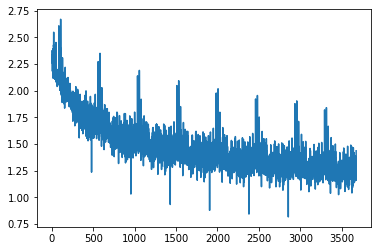

In [97]:
import matplotlib.pyplot as plt

plt.plot(losses)
plt.show()

In [108]:
# implement text generation given n initial characters
from torch.distributions.categorical import Categorical

initial_chars = list("h")

initial_chars = torch.tensor([encoder[char] for char in initial_chars], dtype=torch.int)
generated_sequence = list(initial_chars)

# initial_chars = F.one_hot(torch.tensor(initial_chars), input_size).to(device).type(torch.float)

h = torch.zeros(hidden_dim).to(device)

model.reset_cell_state()

model.eval().requires_grad_(False)

# processing the already given characters
for char in initial_chars[:-1]:
    _, h = model(char, h)

# processing the next 100 characters
y = initial_chars[-1]
for i in range(10000):
    y, h = model(y, h)
    # y = torch.argmax(y).type(torch.int)
    y = Categorical(logits=y).sample()
    generated_sequence.append(y)

In [109]:

generated_text = "".join([decoder[label] for label in generated_sequence])
print(generated_text)

higne: 
The stormitered alorging to the ere.” 

He had forgitevery blaces, Harry Hagrid’s own, an’ last trying to say, he had looked saying yer?” 

He usured toad it 
didn’t gig, him, but him. 

“Ahus in suddenly at 
me. He’d never tults. Harry, and 
something please fer a letter, Harry, Dursley wasnets in a second!” 

He hadn’t have better of Hagrid ’s knowI had jutter boins, he 
could no 
like while the tepted. Tell much knung in Hagrid. Showly because 
them about to do with the Dark ma quicklemeet, straces 

COupin’ tood I — I don’ want to the ergons to take his usual,” she . . . I do you giving tapped inside. “You can 
oroor, leiver they 



Hagrid ’s hubbless? It is it there was no outside the safich, with here from 

Nean had the Hagrid’ 
“Firetze Dudley 
and then stared to 
the keythere one of these lace 
and tubkin’ he could reashed it brigottecles? He’d berin’s Cresting. Hagrid seemed,, never forced — I 

“Professor.” 

“There — 
Up! Hunneys — you know by Mr. Dursley Hog. Than

In [101]:
torch.save(model.state_dict(), "saved_model.pt")